# Import

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.graph_objects as go

# DỮ LIỆU

## GIÁ CÀ PHÊ

In [ ]:
df_coffee = pd.read_csv('https://raw.githubusercontent.com/thuongh2/FinalProject/main/data/gia_ca_phe_den_2023.csv', encoding='ISO-8859-1')
df_coffee.head()

,date,price
0,1/2/2007,21600.0
1,1/3/2007,22000.0
2,1/4/2007,21700.0
3,1/5/2007,22000.0
4,1/6/2007,22000.0


In [ ]:
df_coffee.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6208 entries, 0 to 6207
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    6208 non-null   object 
 1   price   6208 non-null   float64
dtypes: float64(1), object(1)
memory usage: 97.1+ KB


In [ ]:
df_coffee['date'] = pd.to_datetime(df_coffee['date'])
df_coffee.set_index('date', inplace=True)

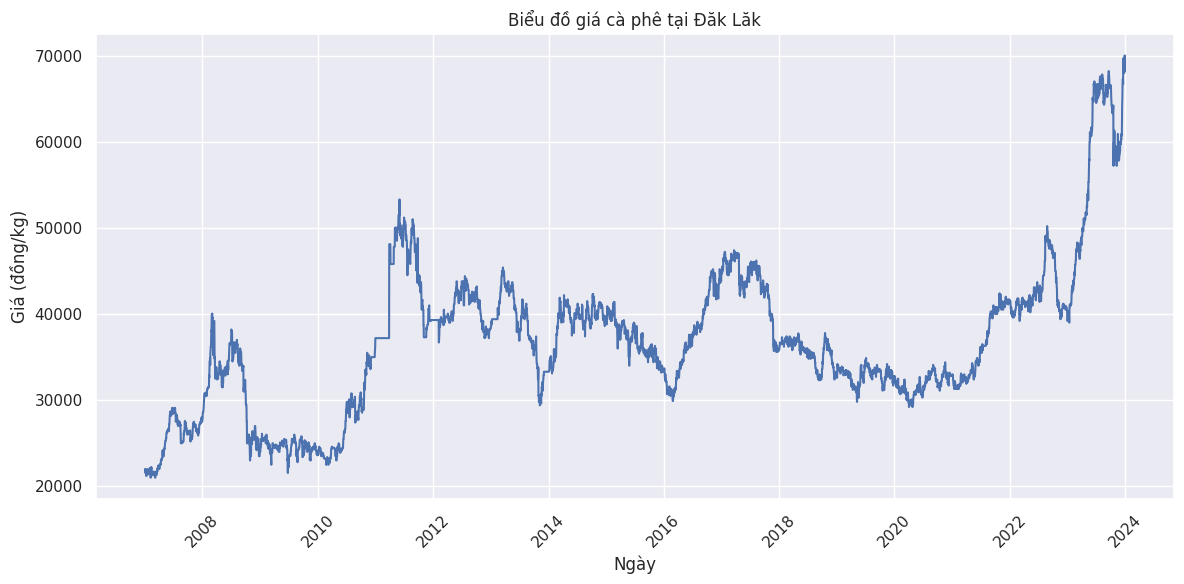

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_coffee, x=df_coffee.index, y='price')
plt.title('Biểu đồ giá cà phê tại Đăk Lăk')
plt.xlabel('Ngày')
plt.ylabel('Giá (đồng/kg)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## XUẤT KHẨU VÀ PHÊ

In [ ]:
df_coffee_export = pd.read_csv('https://raw.githubusercontent.com/thuongh2/FinalProject/main/data/gia_xuat_khau_ca_phe.csv', encoding='ISO-8859-1')
df_coffee_export.head()

,date,Luong (nghin tan),Kim ngach (trieu USD),Trieu USD/ Nghin tan
0,1/1/2009,151.13,232.00,1.535102
1,2/1/2009,154.40,236.62,1.532513
2,3/1/2009,137.02,199.81,1.458254
3,4/1/2009,123.77,180.16,1.455603
4,5/1/2009,93.09,134.10,1.440541


In [ ]:
df_coffee_export['date'] = pd.to_datetime(df_coffee_export['date'])
df_coffee_export.set_index('date', inplace=True)

### Xử lý outlier

<Axes: >

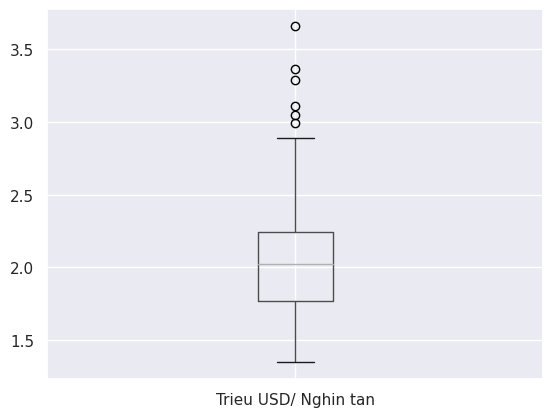

In [ ]:
df_coffee_export[['Trieu USD/ Nghin tan']].boxplot()

In [ ]:
# Tính toán ngưỡng cho outlier sử dụng IQR
Q1 = df_coffee_export['Trieu USD/ Nghin tan'].quantile(0.25)
Q3 = df_coffee_export['Trieu USD/ Nghin tan'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [ ]:
# Xác định các dòng dữ liệu có giá trị nằm ngoài ngưỡng
outliers = df_coffee_export[(df_coffee_export['Trieu USD/ Nghin tan'] < lower_bound) | (df_coffee_export['Trieu USD/ Nghin tan'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

Số lượng outlier: 6


In [ ]:
# Kiểm tra và thay đổi giá trị nếu nó nằm ngoài ngưỡng
df_coffee_export.at[df_coffee_export.index[0], 'Trieu USD/ Nghin tan'] = min(max(df_coffee_export.iloc[0]['Trieu USD/ Nghin tan'], lower_bound), upper_bound)

# Thay thế giá trị của outlier bằng giá trị trước đó
for index, row in outliers.iterrows():
    previous_date_index = df_coffee_export.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df_coffee_export.index[previous_date_index]
        previous_value = df_coffee_export.loc[previous_date, 'Trieu USD/ Nghin tan']
        df_coffee_export.at[index, 'Trieu USD/ Nghin tan'] = previous_value

<Axes: >

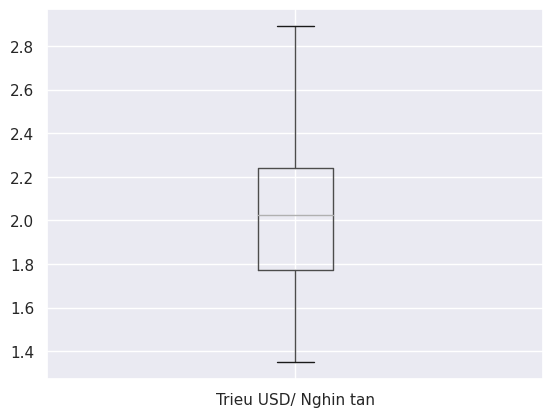

In [ ]:
df_coffee_export[['Trieu USD/ Nghin tan']].boxplot()

### Fill dữ liệu ngày bị thiếu

In [ ]:
idx = pd.date_range(df_coffee_export.index.min(), df_coffee_export.index.max())
df_coffee_export = df_coffee_export.reindex(idx)

In [ ]:
df_coffee_export.fillna(method='ffill', inplace=True)
df_coffee_export.head()

,Luong (nghin tan),Kim ngach (trieu USD),Trieu USD/ Nghin tan
2009-01-01,151.13,232.0,1.535102
2009-01-02,151.13,232.0,1.535102
2009-01-03,151.13,232.0,1.535102
2009-01-04,151.13,232.0,1.535102
2009-01-05,151.13,232.0,1.535102


### Merge dữ liệu xuất khẩu vào giá cà phê

In [ ]:
start_date = df_coffee_export.index.min()
df_coffee_filtered = df_coffee.loc[start_date:]

df_merged_coffee_export = pd.merge(df_coffee_filtered, df_coffee_export[['Trieu USD/ Nghin tan']], left_index=True, right_index=True, how='left')
df_merged_coffee_export['Trieu USD/ Nghin tan'] = df_merged_coffee_export['Trieu USD/ Nghin tan'].ffill()

print(df_merged_coffee_export.tail())

              price  Trieu USD/ Nghin tan
date                                     
2023-12-27  68000.0              2.892161
2023-12-28  68850.0              2.892161
2023-12-29  70000.0              2.892161
2023-12-30  68200.0              2.892161
2023-12-31  68200.0              2.892161


## GIÁ XĂNG

In [ ]:
df_gasoline = pd.read_csv('https://raw.githubusercontent.com/thuongh2/FinalProject/main/data/gia_xang.csv', encoding='ISO-8859-1')
df_gasoline.tail()

,date,RON 95-III
170,2/5/2024,24.95
171,9/5/2024,23.54
172,16/05/2024,23.13
173,23/05/2024,23.21
174,29/05/2024,23.21


### Xử lý outlier

<Axes: >

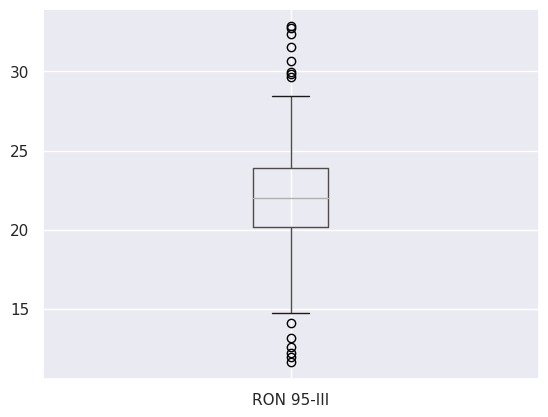

In [ ]:
df_gasoline[['RON 95-III']].boxplot()

In [ ]:
# Tính toán ngưỡng cho outlier sử dụng IQR
Q1 = df_gasoline['RON 95-III'].quantile(0.25)
Q3 = df_gasoline['RON 95-III'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [ ]:
# Xác định các dòng dữ liệu có giá trị nằm ngoài ngưỡng
outliers = df_gasoline[(df_gasoline['RON 95-III'] < lower_bound) | (df_gasoline['RON 95-III'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

Số lượng outlier: 14


In [ ]:
# Kiểm tra và thay đổi giá trị nếu nó nằm ngoài ngưỡng
df_gasoline.at[df_gasoline.index[0], 'RON 95-III'] = min(max(df_gasoline.iloc[0]['RON 95-III'], lower_bound), upper_bound)

# Thay thế giá trị của outlier bằng giá trị trước đó
for index, row in outliers.iterrows():
    previous_date_index = df_gasoline.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df_gasoline.index[previous_date_index]
        previous_value = df_gasoline.loc[previous_date, 'RON 95-III']
        df_gasoline.at[index, 'RON 95-III'] = previous_value

<Axes: >

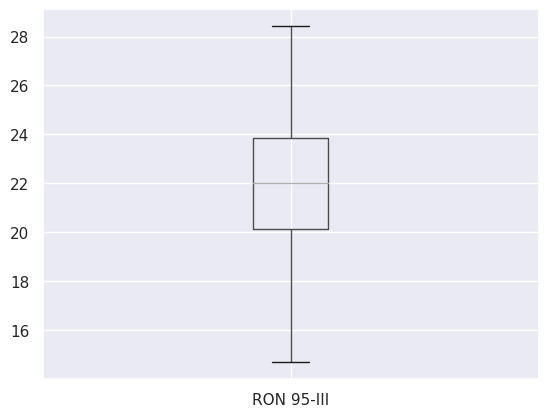

In [ ]:
df_gasoline[['RON 95-III']].boxplot()

### Fill dữ liệu ngày bị thiếu

In [ ]:
df_gasoline['date'] = pd.to_datetime(df_gasoline['date'])
df_gasoline.set_index('date', inplace=True)

<ipython-input-84-2ca4586e2886>:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_gasoline['date'] = pd.to_datetime(df_gasoline['date'])


In [ ]:
idx = pd.date_range(df_gasoline.index.min(), df_gasoline.index.max())
df_gasoline = df_gasoline.reindex(idx)
df_gasoline.fillna(method='ffill', inplace=True)

### Merge dữ liệu xăng với cà phê

In [ ]:
start_date = df_gasoline.index.min()
df_coffee_filtered = df_coffee.loc[start_date:]

df_merged_gasoline = pd.merge(df_coffee_filtered, df_gasoline[['RON 95-III']], left_index=True, right_index=True, how='left')
df_merged_gasoline['RON 95-III'] = df_merged_gasoline['RON 95-III'].ffill()

print(df_merged_gasoline.tail())

              price  RON 95-III
date                           
2023-12-27  68000.0       22.14
2023-12-28  68850.0       22.14
2023-12-29  70000.0       22.14
2023-12-30  68200.0       22.14
2023-12-31  68200.0       22.14


# Mô hình dự đoán

## Giá cà phê kết hợp giá xuất khẩu

### Xây dựng mô hình

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
df_coffee_export_predictions = df_merged_coffee_export.copy()

scaler_price = MinMaxScaler(feature_range=(0, 1))
scaled_price = scaler_price.fit_transform(df_coffee_export_predictions[['price']])

scaler_export = MinMaxScaler(feature_range=(0, 1))
scaled_export = scaler_export.fit_transform(df_coffee_export_predictions[['Trieu USD/ Nghin tan']])

scaled_data = np.concatenate((scaled_price, scaled_export), axis=1)

In [ ]:
seq_length = 30
X, y = create_sequences(scaled_data, seq_length)

In [ ]:
X.shape, y.shape

((5448, 30, 2), (5448,))

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Kích thước tập huấn luyện:", X_train.shape, y_train.shape)
print("Kích thước tập kiểm tra:", X_test.shape, y_test.shape)

Kích thước tập huấn luyện: (4358, 30, 2) (4358,)
Kích thước tập kiểm tra: (1090, 30, 2) (1090,)


In [ ]:
model_coffee_export = Sequential()
model_coffee_export.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(seq_length, 2)))
model_coffee_export.add(Dropout(0.2))
model_coffee_export.add(Bidirectional(LSTM(units=64), input_shape=(seq_length, 1)))
model_coffee_export.add(Dropout(0.2))
model_coffee_export.add(Dense(units=64, activation='tanh'))
model_coffee_export.add(Dense(units=1))

In [ ]:
model_coffee_export.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [ ]:
model_coffee_export.fit(X_train, y_train, epochs=50, batch_size=64, callbacks=[early_stopping])

Epoch 1/50
69/69 [==============================] - 21s 190ms/step - loss: 0.0061
Epoch 2/50
69/69 [==============================] - 13s 184ms/step - loss: 8.7487e-04
Epoch 3/50
69/69 [==============================] - 12s 181ms/step - loss: 7.4901e-04
Epoch 4/50
69/69 [==============================] - 12s 180ms/step - loss: 5.9958e-04
Epoch 5/50
69/69 [==============================] - 14s 196ms/step - loss: 5.4468e-04
Epoch 6/50
69/69 [==============================] - 13s 183ms/step - loss: 4.7382e-04
Epoch 7/50
69/69 [==============================] - 14s 203ms/step - loss: 4.9126e-04
Epoch 8/50
69/69 [==============================] - 13s 185ms/step - loss: 3.9854e-04
Epoch 9/50
69/69 [==============================] - 13s 184ms/step - loss: 3.6734e-04
Epoch 10/50
69/69 [==============================] - 13s 193ms/step - loss: 3.3763e-04
Epoch 11/50
69/69 [==============================] - 13s 184ms/step - loss: 3.1087e-04
Epoch 12/50
69/69 [==============================] - 12s

### Dự đoán trên tập train

In [ ]:
train_predictions = model_coffee_export.predict(X_train)

137/137 [==============================] - 8s 50ms/step


In [ ]:
train_predictions = scaler_price.inverse_transform(train_predictions)
y_train = scaler_price.inverse_transform(y_train.reshape(-1, 1))

In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_mape = calculate_mape(y_train, train_predictions)

print(f'Training RMSE: {train_rmse:.2f}')
print(f'Training MAPE: {train_mape:.2f}%')

Training RMSE: 572.09
Training MAPE: 1.17%


In [ ]:
dates = df_coffee.index.tolist()

fig = go.Figure()

fig.add_trace(go.Scatter(x=dates[:len(y_train)], y=y_train.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=dates[:len(train_predictions)], y=train_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá cà phê trên tập huấn luyện (mô hình BiLSTM, dữ liệu giá cà phê và xuất khẩu)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_mape = calculate_mape(y_train, train_predictions)

print(f'Training RMSE: {train_rmse:.2f}')
print(f'Training MAPE: {train_mape:.2f}%')

Training RMSE: 572.09
Training MAPE: 1.17%


### Dự đoán trên tập test

In [ ]:
test_predictions = model_coffee_export.predict(X_test)

35/35 [==============================] - 1s 36ms/step


In [ ]:
test_predictions = scaler_price.inverse_transform(test_predictions)
y_test = scaler_price.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mape = calculate_mape(y_test, test_predictions)

print(f'Testing RMSE: {test_rmse:.2f}')
print(f'Testing MAPE: {test_mape:.2f}%')

Testing RMSE: 770.61
Testing MAPE: 1.19%


In [ ]:
dates = df_coffee.index.tolist()

fig = go.Figure()

fig.add_trace(go.Scatter(x=dates[:len(y_test)], y=y_test.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=dates[:len(test_predictions)], y=test_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá cà phê trên tập kiểm tra (mô hình BiLSTM, dữ liệu giá cà phê và xuất khẩu)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

### Đánh giá kết quả

In [ ]:
results = pd.DataFrame({
    '': ['Train', 'Test'],
    'RMSE': [train_rmse, test_rmse],
    'MAPE (%)': [train_mape, test_mape]
})
results = results.round(2)

print(results)

            RMSE  MAPE (%)
0  Train  572.09      1.17
1   Test  770.61      1.19


### Lưu mô hình

In [ ]:
# from tensorflow.keras.models import load_model

# model_coffee_export.save('/content/drive/MyDrive/KLTN/SavedModels/LSTM_multivariate_coffee_export.h5')

## Giá cà phê kết hợp giá xăng

### Xây dựng mô hình

In [ ]:
# Preprocess data
scaler_price = MinMaxScaler(feature_range=(0, 1))
scaled_price = scaler_price.fit_transform(df_merged_gasoline[['price']])

scaler_export = MinMaxScaler(feature_range=(0, 1))
scaled_export = scaler_export.fit_transform(df_merged_gasoline[['RON 95-III']])

scaled_data = np.concatenate((scaled_price, scaled_export), axis=1)

In [ ]:
seq_length = 30
X, y = create_sequences(scaled_data, seq_length)

In [ ]:
X.shape, y.shape

((1928, 30, 2), (1928,))

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Kích thước tập huấn luyện:", X_train.shape, y_train.shape)
print("Kích thước tập kiểm tra:", X_test.shape, y_test.shape)

Kích thước tập huấn luyện: (1542, 30, 2) (1542,)
Kích thước tập kiểm tra: (386, 30, 2) (386,)


In [ ]:
model_gasoline = Sequential()
model_gasoline.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(seq_length, 2)))
model_gasoline.add(Dropout(0.2))
model_gasoline.add(Bidirectional(LSTM(units=64), input_shape=(seq_length, 1)))
model_gasoline.add(Dropout(0.2))
model_gasoline.add(Dense(units=64, activation='tanh'))
model_gasoline.add(Dense(units=1))

In [ ]:
model_gasoline.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [ ]:
model_gasoline.fit(X_train, y_train, epochs=50, batch_size=64, callbacks=[early_stopping])

Epoch 1/50
25/25 [==============================] - 14s 163ms/step - loss: 0.0062
Epoch 2/50
25/25 [==============================] - 4s 163ms/step - loss: 8.7213e-04
Epoch 3/50
25/25 [==============================] - 6s 232ms/step - loss: 6.3165e-04
Epoch 4/50
25/25 [==============================] - 4s 160ms/step - loss: 4.9017e-04
Epoch 5/50
25/25 [==============================] - 4s 161ms/step - loss: 4.2962e-04
Epoch 6/50
25/25 [==============================] - 6s 228ms/step - loss: 4.1643e-04
Epoch 7/50
25/25 [==============================] - 4s 161ms/step - loss: 3.5611e-04
Epoch 8/50
25/25 [==============================] - 4s 162ms/step - loss: 3.5867e-04
Epoch 9/50
25/25 [==============================] - 6s 234ms/step - loss: 3.9890e-04
Epoch 10/50
25/25 [==============================] - 4s 160ms/step - loss: 2.9298e-04
Epoch 11/50
25/25 [==============================] - 4s 161ms/step - loss: 3.0821e-04
Epoch 12/50
25/25 [==============================] - 6s 235ms/step

### Dự đoán trên tập train

In [ ]:
train_predictions = model_gasoline.predict(X_train)

In [ ]:
train_predictions = scaler_price.inverse_transform(train_predictions)
y_train = scaler_price.inverse_transform(y_train.reshape(-1, 1))

In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_mape = calculate_mape(y_train, train_predictions)

print(f'Training RMSE: {train_rmse:.2f}')
print(f'Training MAPE: {train_mape:.2f}%')

In [ ]:
dates = df_coffee.index.tolist()

fig = go.Figure()

fig.add_trace(go.Scatter(x=dates[:len(y_train)], y=y_train.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=dates[:len(train_predictions)], y=train_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá cà phê trên tập huấn luyện (mô hình BiLSTM, dữ liệu giá cà phê và xăng)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

### Dự đoán trên tập test

In [ ]:
test_predictions = model_gasoline.predict(X_test)

In [ ]:
test_predictions = scaler_price.inverse_transform(test_predictions)
y_test = scaler_price.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mape = calculate_mape(y_test, test_predictions)

print(f'Testing RMSE: {test_rmse:.2f}')
print(f'Testing MAPE: {test_mape:.2f}%')

In [ ]:
dates = df_coffee.index.tolist()

fig = go.Figure()

fig.add_trace(go.Scatter(x=dates[:len(y_test)], y=y_test.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=dates[:len(test_predictions)], y=test_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá cà phê trên tập kiểm tra (mô hình BiLSTM, dữ liệu giá cà phê và xuất khẩu)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

### Đánh giá kết quả

In [ ]:
results = pd.DataFrame({
    '': ['Train', 'Test'],
    'RMSE': [train_rmse, test_rmse],
    'MAPE (%)': [train_mape, test_mape]
})
results = results.round(2)

print(results)

### Lưu mô hình

In [ ]:
# from tensorflow.keras.models import load_model

# model_gasoline.save('LSTM_coffee_gasoline.h5')

## Kết hợp giá cà phê, xuất khẩu, giá xăng

### Xây dựng mô hình

In [ ]:
start_date = df_gasoline.index.min()
df_coffee_filtered = df_coffee.loc[start_date:]

df_coffee_merged = pd.merge(df_coffee_filtered, df_coffee_export[['Trieu USD/ Nghin tan']], left_index=True, right_index=True, how='left')
df_coffee_merged['Trieu USD/ Nghin tan'] = df_coffee_merged['Trieu USD/ Nghin tan'].ffill()

df_coffee_merged = pd.merge(df_coffee_merged, df_gasoline[['RON 95-III']], left_index=True, right_index=True, how='left')
df_coffee_merged['RON 95-III'] = df_coffee_merged['RON 95-III'].ffill()

print(df_coffee_merged.tail())

In [ ]:
# Preprocess data
scaler_price = MinMaxScaler(feature_range=(0, 1))
scaled_price = scaler_price.fit_transform(df_coffee_merged[['price']])

scaler_export = MinMaxScaler(feature_range=(0, 1))
scaled_export = scaler_export.fit_transform(df_coffee_merged[['Trieu USD/ Nghin tan']])

scaler_gasoline = MinMaxScaler(feature_range=(0, 1))
scaler_gasoline = scaler_gasoline.fit_transform(df_coffee_merged[['RON 95-III']])

scaled_data = np.concatenate((scaled_price, scaled_export), axis=1)
scaled_data = np.concatenate((scaled_data, scaler_gasoline), axis=1)

In [ ]:
seq_length = 30
X, y = create_sequences(scaled_data, seq_length)

In [ ]:
X.shape, y.shape

In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Kích thước tập huấn luyện:", X_train.shape, y_train.shape)
print("Kích thước tập kiểm tra:", X_test.shape, y_test.shape)

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(units=128), input_shape=(seq_length, 3)))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='tanh'))
model.add(Dense(units=1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=64, callbacks=[early_stopping])

### Dự đoán trên tập train

In [ ]:
train_predictions = model.predict(X_train)

In [ ]:
train_predictions = scaler_price.inverse_transform(train_predictions)
y_train = scaler_price.inverse_transform(y_train.reshape(-1, 1))

In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_mape = calculate_mape(y_train, train_predictions)

print(f'Training RMSE: {train_rmse:.2f}')
print(f'Training MAPE: {train_mape:.2f}%')

In [ ]:
dates = df_coffee.index.tolist()

fig = go.Figure()

fig.add_trace(go.Scatter(x=dates[:len(y_train)], y=y_train.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=dates[:len(train_predictions)], y=train_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá cà phê trên tập huấn luyện (mô hình BiLSTM, dữ liệu giá cà phê, xuất khẩu, xăng)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

### Dự đoán trên tập test

In [ ]:
test_predictions = model.predict(X_test)

In [ ]:
test_predictions = scaler_price.inverse_transform(test_predictions)
y_test = scaler_price.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mape = calculate_mape(y_test, test_predictions)

print(f'Testing RMSE: {test_rmse:.2f}')
print(f'Testing MAPE: {test_mape:.2f}%')

In [ ]:
dates = df_coffee.index.tolist()

fig = go.Figure()

fig.add_trace(go.Scatter(x=dates[:len(y_test)], y=y_test.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=dates[:len(test_predictions)], y=test_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá cà phê trên tập kiểm tra (mô hình BiLSTM, dữ liệu giá cà phê, xuất khẩu, xăng)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

### Đánh giá kết quả

In [ ]:
results = pd.DataFrame({
    '': ['Train', 'Test'],
    'RMSE': [train_rmse, test_rmse],
    'MAPE (%)': [train_mape, test_mape]
})
results = results.round(2)

print(results)